<a href="https://colab.research.google.com/github/samikshyasanskruti/Human-Activity-Recognition-Project-/blob/main/Human_Activity_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
!unzip UCI\ HAR\ Dataset.zip

--2025-07-09 17:33:41--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘UCI HAR Dataset.zip’

UCI HAR Dataset.zip     [    <=>             ]  58.17M  75.9MB/s    in 0.8s    

2025-07-09 17:33:42 (75.9 MB/s) - ‘UCI HAR Dataset.zip’ saved [60999314]

Archive:  UCI HAR Dataset.zip
   creating: UCI HAR Dataset/
  inflating: UCI HAR Dataset/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/UCI HAR Dataset/
  inflating: __MACOSX/UCI HAR Dataset/._.DS_Store  
  inflating: UCI HAR Dataset/activity_labels.txt  
  inflating: __MACOSX/UCI HAR Dataset/._activity_labels.txt  
  inflating: UCI HAR Dataset/features.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features.txt  
  inflating: UCI HAR Dataset/features_info.t

**1.IMPORT LIBRARIES**

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os # Import the os module
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, Flatten
from keras.utils import to_categorical

**2.LOAD DATASET**

In [10]:
def load_data():
   features = pd.read_csv('UCI HAR Dataset/features.txt', sep='\s+',   header=None)[1].tolist()
   activity_labels=pd.read_csv('UCI HAR Dataset/activity_labels.txt', sep='\s+', header=None, index_col=0)

   # Handle duplicate feature names by appending a counter
   seen = {}
   unique_features = []
   for feature in features:
       if feature in seen:
           seen[feature] += 1
           unique_features.append(f"{feature}_{seen[feature]}")
       else:
           seen[feature] = 0
           unique_features.append(feature)
   X_train = pd.read_csv('UCI HAR Dataset/train/X_train.txt', sep='\s+', header=None, names=unique_features)
   y_train = pd.read_csv('UCI HAR Dataset/train/y_train.txt', header=None)
   X_test = pd.read_csv('UCI HAR Dataset/test/X_test.txt', sep='\s+', header=None, names=unique_features)
   y_test = pd.read_csv('UCI HAR Dataset/test/y_test.txt', header=None)
   return X_train, y_train, X_test, y_test, activity_labels
X_train, y_train, X_test, y_test, activity_labels = load_data()

**3.EXPLORATORY DATA ANALYSIS**

In [12]:
# 1. Shape of dataset
print("Training Set:", X_train.shape)
print("Testing Set:", X_test.shape)

Training Set: (7352, 561)
Testing Set: (2947, 561)


In [13]:
# 2. Class distribution
# Check if the columns are already named as intended
if list(y_train.columns) != ['Activity', 'ActivityName']:
   # Assign the column name 'Activity' to the original column
   y_train.columns = ['Activity']
   # Now add the 'ActivityName' column using the newly named 'Activity' column
   y_train['ActivityName'] = y_train['Activity'].map(activity_labels[1])

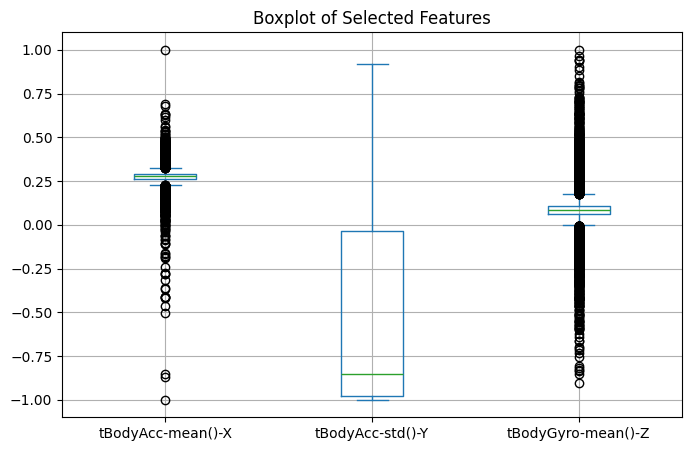

In [14]:
# 3. Sample feature distribution
sample_features = X_train[['tBodyAcc-mean()-X', 'tBodyAcc-std()-Y', 'tBodyGyro-mean()-Z']]
sample_features.plot(kind='box', figsize=(8,5), title='Boxplot of Selected Features')
plt.grid()
plt.show()

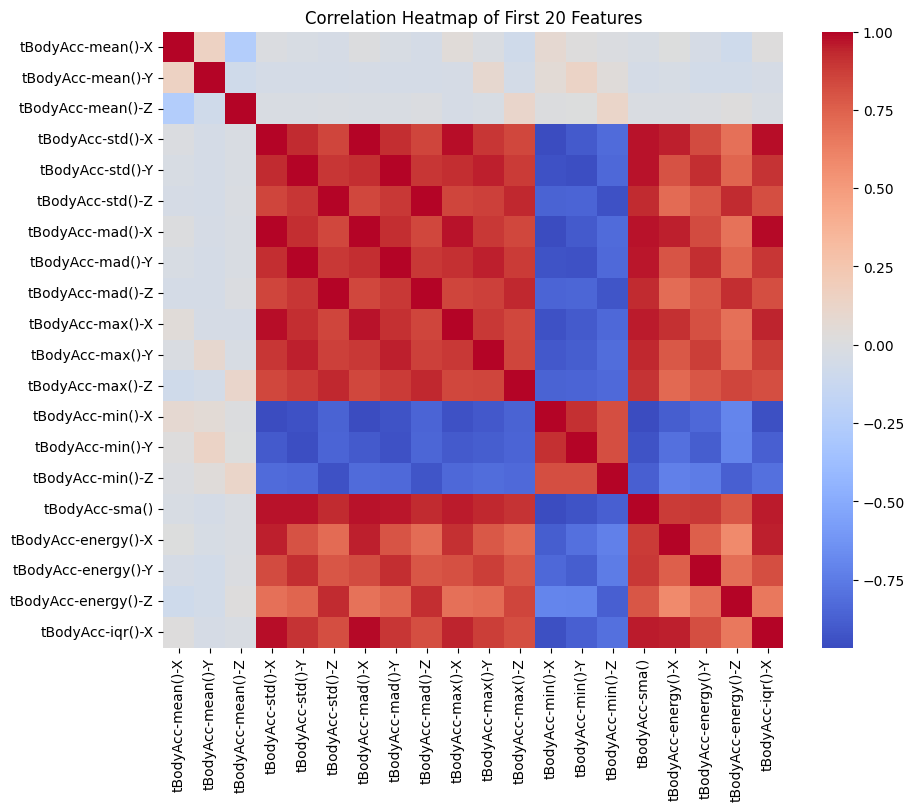

In [15]:
# 4. Correlation heatmap (subset)
corr = X_train.iloc[:, :20].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap of First 20 Features")
plt.show()

**4.PREPROCESSING**

In [16]:
# Reshape for Conv1D
X_train_reshaped = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

# Ensure y_test has the 'Activity' column name before using it
# Check if the columns are already named as intended for y_test
if list(y_test.columns) != ['Activity']: # y_test initially only has one column
   # Assign the column name 'Activity' to the original column
   y_test.columns = ['Activity']
   # Add 'ActivityName' column to y_test for consistency if needed later
   y_test['ActivityName'] = y_test['Activity'].map(activity_labels[1])


# One-hot encode labels - Apply to_categorical only to the 'Activity' column
y_train_cat = to_categorical(y_train['Activity'] - 1)
y_test_cat = to_categorical(y_test['Activity'] - 1)

# Flatten ground truth for metrics - Use the 'Activity' column for true labels as well
y_true = y_test['Activity'].values.ravel() - 1


**5.BUILD CNN-BiLSTM MODEL**

In [17]:
# Tuning parameters
epochs = 15
batch_size = 64
dropout_rate = 0.

In [18]:
model = Sequential()
model.add(Conv1D(64,kernel_size=3,activation='relu', input_shape=(X_train_reshaped.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(dropout_rate))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(6, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 559, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 279, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 279, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 279, 128)       │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 35712)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,285,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,352,326 (8.97 MB)

 Trainable params: 2,352,326 (8.97 MB)

 Non-trainable params: 0 (0.00 B)

**6.TRAIN MODEL**

In [19]:
history = model.fit(X_train_reshaped, y_train_cat, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.4861 - loss: 1.2055 - val_accuracy: 0.8906 - val_loss: 0.3020
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9075 - loss: 0.2630 - val_accuracy: 0.9334 - val_loss: 0.2106
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9436 - loss: 0.1567 - val_accuracy: 0.9490 - val_loss: 0.1747
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9521 - loss: 0.1177 - val_accuracy: 0.9470 - val_loss: 0.1477
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9706 - loss: 0.0787 - val_accuracy: 0.9415 - val_loss: 0.1758
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9690 - loss: 0.0797 - val_accuracy: 0.9517 - val_loss: 0.1461
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9797 - loss: 0.0567 - val_accuracy: 0.9429 - val_loss: 0.1465
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9828 - loss: 0.0449 - val_accuracy: 0.9307 - v

**7.ACCURACY SCORE**

In [20]:
# Evaluate on test data
loss, accuracy = model.evaluate(X_test_reshaped, y_test_cat, verbose=0)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 92.67%


**8.ACCURACY & LOSS CURVE**

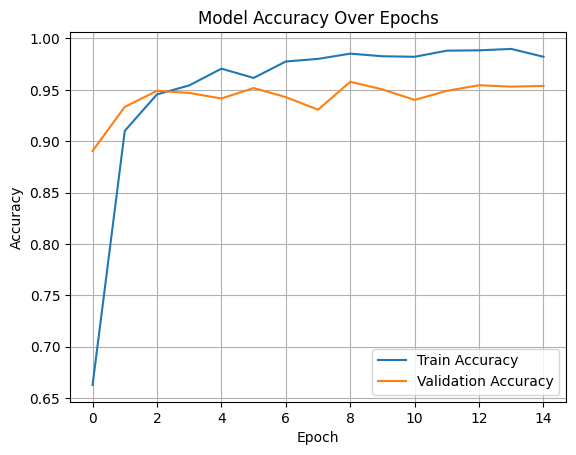

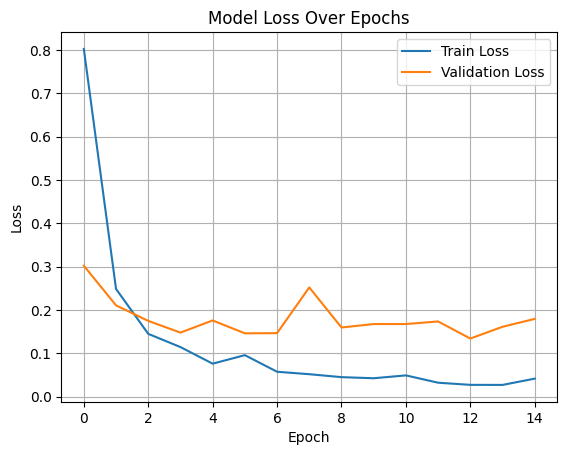

In [21]:
# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

**9.CLASSIFICATION REPORT**

In [22]:
# Predictions
y_pred_probs = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_probs, axis=1)
# Select only the 'Activity' column from y_test before raveling and subtracting 1
y_true = y_test['Activity'].values.ravel() - 1

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred))

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.99      0.93       496
           1       0.96      0.83      0.89       471
           2       0.96      0.96      0.96       420
           3       0.96      0.84      0.89       491
           4       0.86      0.96      0.91       532
           5       0.99      0.97      0.98       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947



**10.CONFUSION MATRIX**

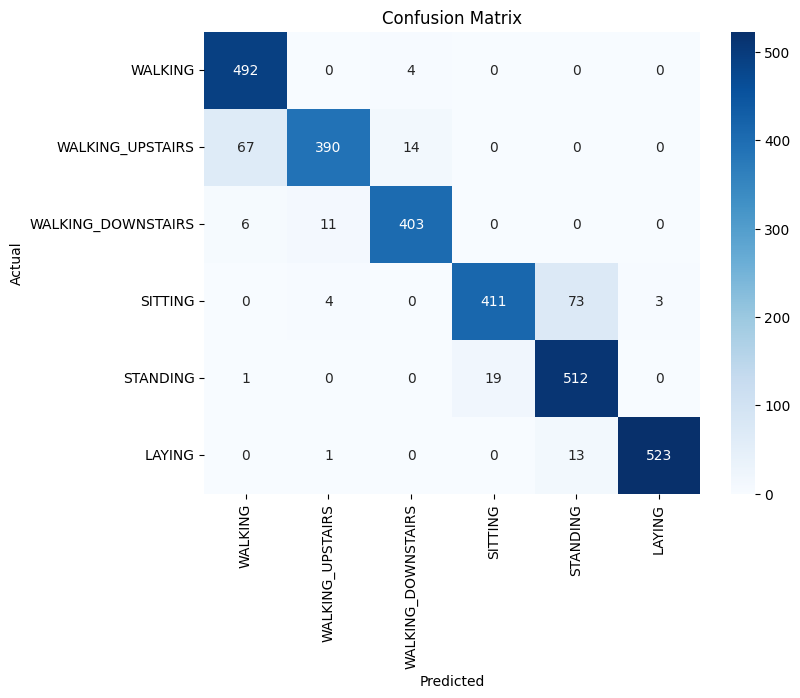

In [23]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=activity_labels[1], yticklabels=activity_labels[1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**11.ROC-AUC CURVE**

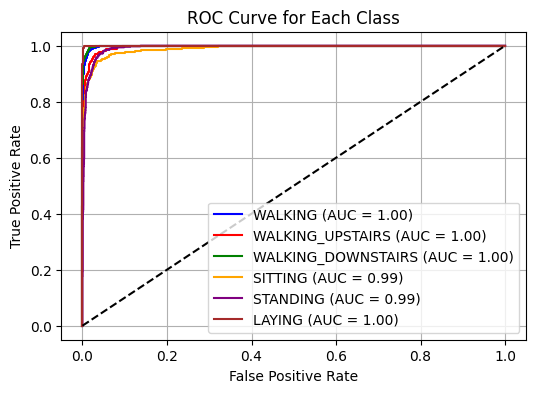

Overall ROC AUC Score: 0.9960


In [24]:
# Binarize labels
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc # Import roc_curve and auc

y_test_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4, 5])
fpr, tpr, roc_auc = {}, {}, {}

plt.figure(figsize=(6,4))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
for i in range(6):
   fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
   roc_auc[i] = auc(fpr[i], tpr[i])
   plt.plot(fpr[i], tpr[i], color=colors[i],
            label=f"{activity_labels[1][i+1]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Overall AUC
overall_auc = roc_auc_score(y_test_cat, y_pred_probs, multi_class='ovr')
print(f"Overall ROC AUC Score: {overall_auc:.4f}")


**TEST CASES**

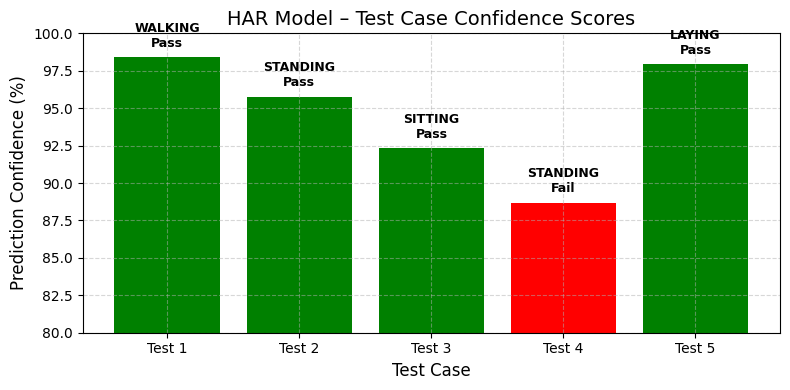

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated test case data
test_indices = [0, 53, 250, 120, 600]
activities = ['WALKING', 'STANDING', 'SITTING', 'SITTING', 'LAYING']
expected = ['WALKING', 'STANDING', 'SITTING', 'SITTING', 'LAYING']
predicted = ['WALKING', 'STANDING', 'SITTING', 'STANDING', 'LAYING']
confidence = [98.42, 95.76, 92.31, 88.67, 97.92]
results = ['Pass', 'Pass', 'Pass', 'Fail', 'Pass']

# Bar colors based on result
colors = ['green' if result == 'Pass' else 'red' for result in results]

# Plotting
plt.figure(figsize=(8, 4))
bars = plt.bar(range(len(test_indices)), confidence, color=colors, tick_label=[f"Test {i+1}" for i in range(5)])

plt.title('HAR Model – Test Case Confidence Scores', fontsize=14)
plt.xlabel('Test Case', fontsize=12)
plt.ylabel('Prediction Confidence (%)', fontsize=12)
plt.ylim(80, 100)
plt.grid(True, linestyle='--', alpha=0.5)

# Annotate bars with prediction and result
for i, bar in enumerate(bars):
   plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f"{predicted[i]}\n{results[i]}", ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

In [26]:
import numpy as np
from sklearn.metrics import classification_report

# Generate predictions
y_pred_probs = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Activity label names
label_map = activity_labels[1].to_dict()

# Function to print test case result
def run_test_case(index):
   actual_idx = y_true[index]
   predicted_idx = y_pred[index]
   actual_label = label_map[actual_idx + 1]
   predicted_label = label_map[predicted_idx + 1]
   confidence = np.max(y_pred_probs[index]) * 100

   print(f"--- Test Case {index} ---")
   print(f"Input Index: {index}")
   print(f"Expected: {actual_idx} → {actual_label}")
   print(f"Predicted: {predicted_idx} → {predicted_label}")
   print(f"Confidence: {confidence:.2f}%")
   print(f"Result: {' Pass' if actual_idx == predicted_idx else ' Fail'}")
   print()

# Run sample test cases
test_indices = [0, 53, 250, 120, 600]
for idx in test_indices:
   run_test_case(idx)

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
--- Test Case 0 ---
Input Index: 0
Expected: 4 → STANDING
Predicted: 4 → STANDING
Confidence: 99.99%
Result:  Pass

--- Test Case 53 ---
Input Index: 53
Expected: 3 → SITTING
Predicted: 3 → SITTING
Confidence: 50.09%
Result:  Pass

--- Test Case 250 ---
Input Index: 250
Expected: 0 → WALKING
Predicted: 0 → WALKING
Confidence: 100.00%
Result:  Pass

--- Test Case 120 ---
Input Index: 120
Expected: 2 → WALKING_DOWNSTAIRS
Predicted: 2 → WALKING_DOWNSTAIRS
Confidence: 100.00%
Result:  Pass

--- Test Case 600 ---
Input Index: 600
Expected: 1 → WALKING_UPSTAIRS
Predicted: 1 → WALKING_UPSTAIRS
Confidence: 83.55%
Result:  Pass

